In [25]:
%matplotlib inline

In [1]:
import datetime
import math
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
comments = pd.read_csv("/usr/src/app/data/ka-comments.csv")

print "Total size: %d" % len(comments)

print comments[:10]

Total size: 1145440
                  video                                        id  \
0  ancient-temples-nara  33ae6dffe9efdf1bba47412945f3f96ee85e39f7   
1  ancient-temples-nara  ea997873e7cd069c8a6bf2f14809950ac237001c   
2  ancient-temples-nara  61b80f281d1ac24d102535496ad3a963e226cdeb   
3  ancient-temples-nara  49349c01d95f512a04da8f32d54e4aa22d7ec8a9   
4  ancient-temples-nara  847d456003e470c236375a5195d87dc94b46cfc1   
5  ancient-temples-nara  348392e7888687e821de048609cace4a08da4e18   
6  ancient-temples-nara  58f2adc07ebca4285963c55b2736449f900458bd   
7  ancient-temples-nara  96ca02013d5c2bfe8a1bc29932764a3484d47979   
8  ancient-temples-nara  a0c8b56cac318667d2a8aa124b63ff1d00f97fb0   
9  ancient-temples-nara  dac041cb6faff46c806323837292d153b478c4b6   

                                             content  \
0  Why does the pagoda have 5 stories? Wouldn't t...   
1  5 stories represent  5 elements make up our wo...   
2  Because it's easier to calculate the middle wi...

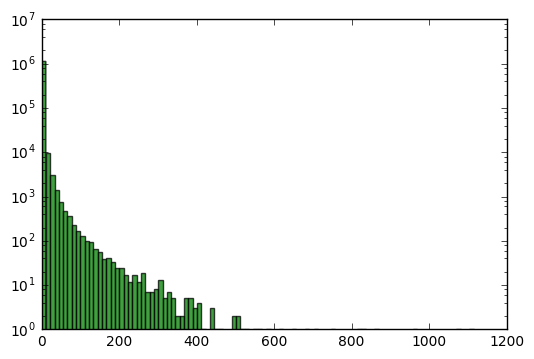

In [3]:
plt.hist(comments["sumVotesIncremented"], 100, facecolor='green', log=True, alpha=0.75)
plt.show()

In [4]:
comments["sumVotesIncremented"].describe()

count    1.145440e+06
mean     1.787104e+00
std      6.694298e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.115000e+03
Name: sumVotesIncremented, dtype: float64

In [20]:
# Turn `sumVotesIncremented` into a binary variable
comments["hasVotes"] = comments["sumVotesIncremented"] > 1
comments["date"] = np.array(comments["date"], dtype="datetime64")
comments["daysAgo"] = pd.Series((comments["date"] - max(comments["date"])).astype('timedelta64[D]'))

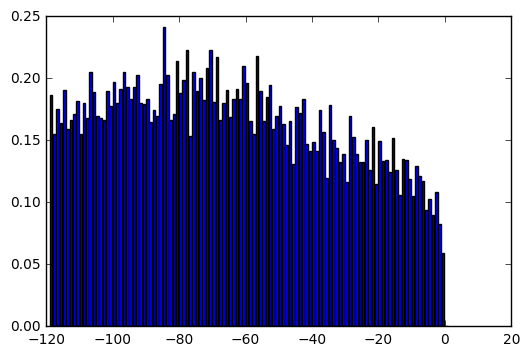

In [21]:
def has_votes_by_date():
    dataframe = pd.DataFrame({
        "daysAgo": comments["daysAgo"],
        "hasVotes": comments["hasVotes"].astype('int'),
    })
    votes_by_date = dataframe[dataframe["daysAgo"] > -120].groupby("daysAgo", as_index=False).mean()
    plt.bar(votes_by_date["daysAgo"], votes_by_date["hasVotes"])
    plt.show()
    
has_votes_by_date()

In [22]:
def transform_scores(data, dataset_name):
    # Count positives
    positive_count = np.sum(data["hasVotes"])
    print "%d / %d comments have votes" % (positive_count, len(data))

    # Generate a balanced set, interleaved TFTF... so we can easily
    # create balanced training/test sets by taking slices
    positive_indices = np.where(data["hasVotes"] == True)[0]
    negative_indices = np.where(data["hasVotes"] == False)[0]
    balanced_indices = [
        val
        for pair in zip(positive_indices, negative_indices[:len(positive_indices)])
        for val in pair]
    print "%d balanced indices" % len(balanced_indices)

    balanced_dataset = data.iloc[balanced_indices]

    validate_size = 5000
    test_size = 5000
    train_size = len(balanced_dataset) - validate_size - test_size
    print "%s: Training set %d, Validate set %d, Test set %d" % (
        dataset_name, train_size, validate_size, test_size)

    dataset = {
        "train_data": balanced_dataset.iloc[:train_size],
        "validate_data": balanced_dataset.iloc[train_size:train_size+validate_size],
        "test_data": balanced_dataset.iloc[train_size+validate_size:train_size+validate_size+test_size],
    }

    with open("/usr/src/app/data/%s.pickle" % dataset_name, "wb") as f:
        pickle.dump(dataset, f)
        
    print "Done."
        
    return dataset

In [23]:
_ = transform_scores(comments[comments["daysAgo"] < -50], "ka-comments-balanced")

249120 / 1102972 comments have votes
498240 balanced indices
ka-comments-balanced: Training set 488240, Validate set 5000, Test set 5000
Done.


In [26]:
def get_replies(comments):
    replies = comments[comments["replyTo"].astype(str) != "nan"]
    replies_joined = pd.merge(replies, comments, how="left", left_on=["replyTo"], right_on=["id"],
                              suffixes=("", "_parent"))
    return replies_joined

_ = transform_scores(get_replies(comments[comments["daysAgo"] < -50]), "ka-replies-balanced")

159108 / 575025 comments have votes
318216 balanced indices
ka-replies-balanced: Training set 308216, Validate set 5000, Test set 5000
Done.
